In [1]:
import tensorflow as tf # Imports tensorflow
from tensorflow import keras
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization,Embedding,TimeDistributed
from tensorflow.keras.layers import Conv2D, MaxPooling2D, ReLU, LSTM,Bidirectional,Attention,Concatenate,concatenate
from tensorflow.keras import regularizers, optimizers,losses
from tensorflow.keras.layers import DepthwiseConv2D,Add, ReLU, GlobalAveragePooling2D, GlobalMaxPooling2D,MultiHeadAttention
from tensorflow.keras.layers import Activation,ActivityRegularization, AvgPool2D, LeakyReLU, Conv2DTranspose
from tensorflow.keras.metrics import Accuracy,Recall,Precision,AUC,TruePositives,TrueNegatives,FalseNegatives,FalsePositives, SpecificityAtSensitivity,SensitivityAtSpecificity
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.python.keras.utils import np_utils
import numpy as np
import pandas as pd 
import matplotlib
import seaborn as sns
import sklearn
#import imblearn
#from keras.optimizers import Adam
import matplotlib.pyplot as plt 
import time
import os
import sklearn.metrics as m
from glob import glob
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
import skimage.io
import skimage.color
import skimage.filters

In [2]:
gr_shape=(128,128,1)
img_shape = (128,128,3)
input_dir="C:/nidhin/abu project/LIDC-IDRI-slices"
images=[]
masks=[]
y=[]
Thres = 5000/255

In the provided code, the following preprocessing steps are performed:

1. Loading Images and Masks:
   - Images and masks are loaded from the specified directories using `image.load_img()` from the Keras preprocessing module. They are resized to the `img_shape`.
   - The images are stored in the `images` list, and the masks are stored in separate lists (`mask0`, `mask1`, `mask2`, `mask3`).

2. Processing Masks and Labels:
   - For each nodule, the white pixel sum is computed for each mask (`mask0`, `mask1`, `mask2`, `mask3`).
   - If the count of white pixels exceeds the threshold (`Thres`) for more than 2 masks, it is labeled as 1 (positive), and the mask with the maximum white pixel sum is chosen. Otherwise, it is labeled as 0 (negative), and the mask with the minimum white pixel sum is chosen.
   - The images, masks, and labels are stored in lists (`images`, `masks`, `y`).

3. Normalization:
   - Images and masks are divided by 255 to normalize pixel values between 0 and 1.

4. Handling Missing Values:
   - Any NaN values in images and masks are replaced with 0 using `np.nan_to_num()`.

5. Data Augmentation:
   - No explicit data augmentation is performed in this snippet.

6. Data Concatenation:
   - Additional data is added to the training set (`x_train_added`, `y_train_added`) by appending a portion of the test set (`x_test`, `y_test`).

Overall, the preprocessing in this code involves loading images and masks, processing masks to determine labels, normalizing the pixel values, handling missing values, and concatenating data for training.

In [3]:
# Iterate over patients in the input directory
for patient in os.listdir(input_dir):
    # Check if the item is a directory
    patient_dir = os.path.join(input_dir, patient)
    if not os.path.isdir(patient_dir):
        continue

    # Break loop if images list exceeds 10000
    if len(images) > 10000:
        break

    # Iterate over nodules in the patient directory
    for nodule in os.listdir(patient_dir):
        nodule_dir = os.path.join(patient_dir, nodule)
        if not os.path.isdir(nodule_dir):
            continue

        mask0 = []
        mask1 = []
        mask2 = []
        mask3 = []

        # Load images
        for filename in glob(os.path.join(nodule_dir, 'images', '*.png')):
            img = image.load_img(filename, target_size=img_shape)
            img = np.asarray(img)
            images.append(img)

        # Load masks
        for i, mask_dir in enumerate([mask0, mask1, mask2, mask3]):
            for filename in glob(os.path.join(nodule_dir, f'mask-{i}', '*.png')):
                img = image.load_img(filename, target_size=img_shape)
                img = np.asarray(img)
                mask_dir.append(img)

        # Process masks and labels
        for i in range(len(mask0)):
            white_sum = np.array([mask.sum() for mask in [mask0[i], mask1[i], mask2[i], mask3[i]]])
            cnt = np.sum(white_sum > Thres)
            if cnt > 2:
                y.append(1)
                max_index = white_sum.argmax()
                masks.append([mask0[i], mask1[i], mask2[i], mask3[i]][max_index])
            else:
                y.append(0)
                min_index = white_sum.argmin()
                masks.append([mask0[i], mask1[i], mask2[i], mask3[i]][min_index])

The code snippet provided iterates over patients in a directory (`input_dir`) and processes their images and masks. Here's how `label` is created based on the masks:

- For each patient, it loads images and masks associated with nodules.
- It then calculates the sum of white pixels in each mask (`mask0`, `mask1`, `mask2`, `mask3`).
- If the count of white pixels exceeding a threshold (`Thres`) is greater than 2, it appends `1` to the label list `label`. Otherwise, it appends `0`.
- Additionally, it selects the mask with the maximum sum of white pixels if the count is greater than 2; otherwise, it selects the mask with the minimum sum of white pixels.
- The selected masks are appended to the `masks` list for further processing.

So, `label` is created based on the count of white pixels in the masks associated with each nodule, with a threshold of `Thres`. If the count exceeds the threshold, it's considered as a positive case (`1`), otherwise, it's considered as a negative case (`0`).

In [4]:
images=np.array(images)/255
masks=np.array(masks)/255
label=np.array(y)
print(images.shape)
print(masks.shape)
print(label.shape)

(10011, 128, 128, 3)
(10011, 128, 128, 3)
(10011,)


In [5]:
yy=pd.DataFrame(label)
yy.value_counts()

1    5097
0    4914
Name: count, dtype: int64

In [6]:
x_train,x_test,y_train,y_test,mask_train,mask_test = train_test_split(images,label,masks,train_size=0.8, random_state=7)
print(x_train.shape)
print(mask_train.shape)

(8008, 128, 128, 3)
(8008, 128, 128, 3)


In [7]:
images = np.nan_to_num(images)
masks = np.nan_to_num(masks )
np.isnan(masks).sum()
masks.shape

(10011, 128, 128, 3)

In [8]:
x_train_added = np.vstack([x_train,x_test[:2000]])
y_train_added = np.concatenate((y_train,y_test[:2000]))
print(x_test.shape)
print(mask_test.shape)
Name='vgg19_custom'

(2003, 128, 128, 3)
(2003, 128, 128, 3)


In [9]:
def mean_iou(y_true, y_pred):
    # Define a function to calculate IoU
    def iou(y_true, y_pred):
        intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
        union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
        iou = K.mean((intersection + K.epsilon()) / (union + K.epsilon()), axis=0)
        return iou
    
    # Compute IoU for each class
    ious = iou(y_true, y_pred)
    # Take the mean over classes (excluding the background)
    return K.mean(ious)

# Define the Matthews correlation coefficient (MCC) custom metric function
def mcc(y_true, y_pred):
    y_pred_pos = tf.keras.backend.round(tf.keras.backend.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos

    y_pos = tf.keras.backend.round(tf.keras.backend.clip(y_true, 0, 1))
    y_neg = 1 - y_pos

    tp = tf.keras.backend.sum(y_pos * y_pred_pos)
    tn = tf.keras.backend.sum(y_neg * y_pred_neg)

    fp = tf.keras.backend.sum(y_neg * y_pred_pos)
    fn = tf.keras.backend.sum(y_pos * y_pred_neg)

    numerator = (tp * tn - fp * fn)
    denominator = tf.keras.backend.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn) + tf.keras.backend.epsilon())

    return numerator / (denominator + tf.keras.backend.epsilon())

In [10]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import Accuracy, Recall, Precision, AUC, MeanIoU
import tensorflow.keras.backend as K

def vgg19_model(input_shape):
    # Load pre-trained VGG19 model without the top classification layers
    vgg19_base = VGG19(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze the layers of the VGG19 model
    for layer in vgg19_base.layers:
        layer.trainable = False

    # Additional convolutional layers for better feature representation
    conv1 = Conv2D(512, (3, 3), activation='relu', padding='same')(vgg19_base.output)
    conv2 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv1)
    conv3 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv2)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv3)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)

    # Upsampling layers to match the target label dimensions
    upsample1 = UpSampling2D(size=(16, 16))(conv5)  # Adjusted to match (128, 128) target size
    upsample2 = UpSampling2D(size=(2, 2))(upsample1)  # Adjusted to match (128, 128) target size

    # Output layer
    outputs = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(upsample2)

    # Create model
    model = Model(inputs=vgg19_base.input, outputs=outputs, name='vgg19_custom')
    return model

# Assuming input shape (height, width, channels) as (128, 128, 3)
input_shape = (128, 128, 3)
vgg19_custom = vgg19_model(input_shape)

def mean_iou(y_true, y_pred):
    # Define a function to calculate IoU
    def iou(y_true, y_pred):
        intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
        union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
        iou = K.mean((intersection + K.epsilon()) / (union + K.epsilon()), axis=0)
        return iou
    
    # Compute IoU for each class
    ious = iou(y_true, y_pred)
    # Take the mean over classes (excluding the background)
    return K.mean(ious)

vgg19_custom.compile(optimizer='adam', loss='binary_crossentropy', metrics=[Accuracy(), Recall(), Precision(), AUC(), mean_iou,mcc])
vgg19_custom.summary()


Model: "vgg19_custom"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)      

In [11]:
with tf.device('/gpu:0'):
     results = vgg19_custom.fit(x_train, mask_train, validation_data=(x_test, mask_test), batch_size=32, epochs=150)

Epoch 1/150
251/251 [==============================] - 1101s 4s/step - loss: 0.0298 - accuracy: 0.0000e+00 - recall: 0.0039 - precision: 0.0082 - auc: 0.8874 - mean_iou: 0.0129 - mcc: 0.0014 - val_loss: 0.0241 - val_accuracy: 0.0000e+00 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_auc: 0.9436 - val_mean_iou: 0.0192 - val_mcc: 0.0000e+00
Epoch 2/150
251/251 [==============================] - 1093s 4s/step - loss: 0.0232 - accuracy: 0.0000e+00 - recall: 4.2363e-04 - precision: 0.4355 - auc: 0.9245 - mean_iou: 0.0176 - mcc: 0.0038 - val_loss: 0.0220 - val_accuracy: 0.0000e+00 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_auc: 0.9448 - val_mean_iou: 0.0189 - val_mcc: 0.0000e+00
Epoch 3/150
251/251 [==============================] - 1093s 4s/step - loss: 0.0218 - accuracy: 0.0000e+00 - recall: 3.7875e-04 - precision: 0.5963 - auc: 0.9380 - mean_iou: 0.0195 - mcc: 0.0047 - val_loss: 0.0219 - val_accuracy: 0.0000e+00 - val_recall: 0.0046 - val_precision: 0.6978 - va

In [12]:
vgg19_custom.save(Name+'.h5')
model = vgg19_custom

c:\Users\nidhi\anaconda3\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [13]:
pd.DataFrame.from_dict(results.history).to_csv(Name+'new.csv',index=False)

In [17]:
new_impr= vgg19_custom.predict(x_train)

251/251 [==============================] - 338s 1s/step


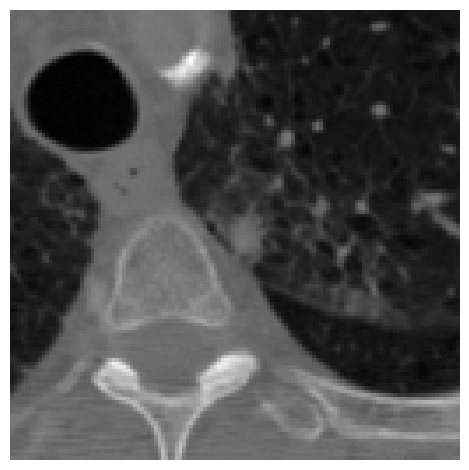

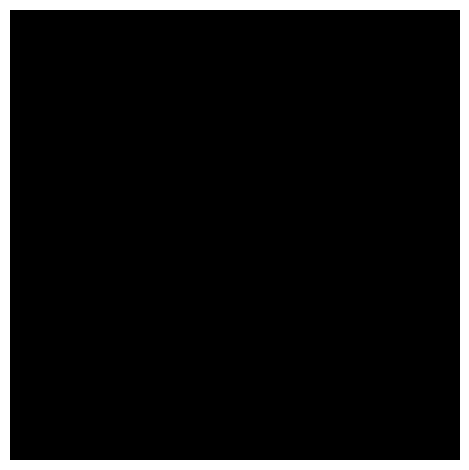

1/1 [==============================] - 0s 92ms/step


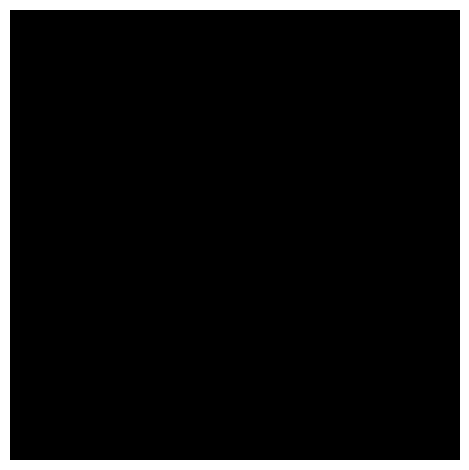

In [15]:

img_id=1019
new_img= np.array(x_train[img_id])
plt.imshow(x_train[img_id])
plt.axis('off')
plt.tight_layout()
plt.show()
plt.imshow(mask_train[img_id])
plt.axis('off')
plt.tight_layout()
plt.show()
new_img = new_img.reshape(1,128,128,3)
new_impr= vgg19_custom.predict(new_img)
plt.imshow(new_impr[0])
plt.axis('off')
plt.tight_layout()
#plt.savefig("Activation_Layer5D7"+'.png')
plt.show()


In [21]:
new_impr[1000]

array([[[1.17185615e-29, 1.53884872e-29, 3.48825485e-29],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [1.97522758e-29, 1.11820624e-28, 8.61114755e-29]],

       [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

       [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00

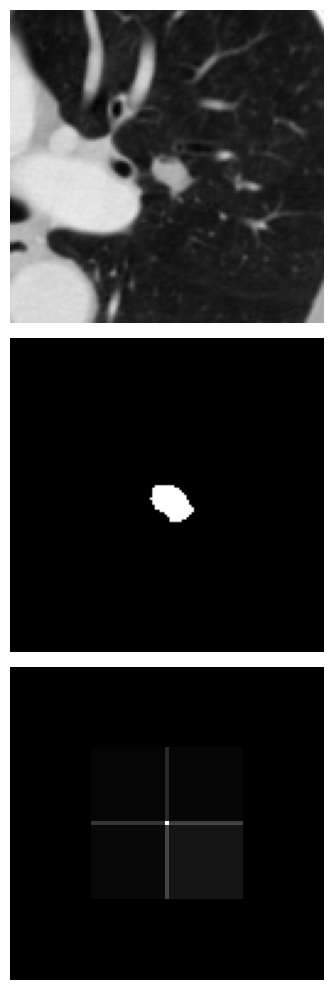

In [34]:
img_id=1789
fig = plt.figure(figsize=(10,10))
a = fig.add_subplot(3, 1, 1)
plt.imshow(x_train[img_id])
#a.set_title("original",fontsize=10)
plt.axis('off')
a = fig.add_subplot(3, 1, 2)
plt.imshow(mask_train[img_id])
#a.set_title("True Mask",fontsize=10)
plt.axis('off')
a = fig.add_subplot(3, 1, 3)
plt.imshow(new_impr[img_id],interpolation='nearest')
#a.set_title("Predicted",fontsize=10)
plt.axis('off')
plt.tight_layout()
plt.savefig("Segmentation"+str(img_id)+'.png')
plt.show()

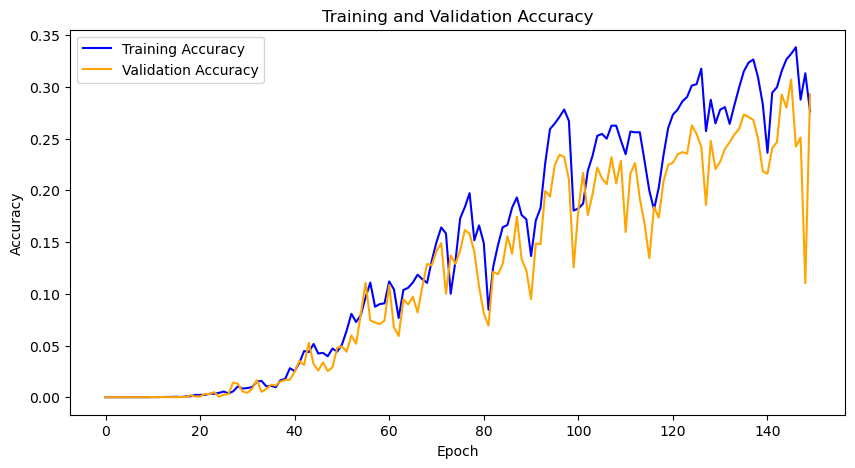

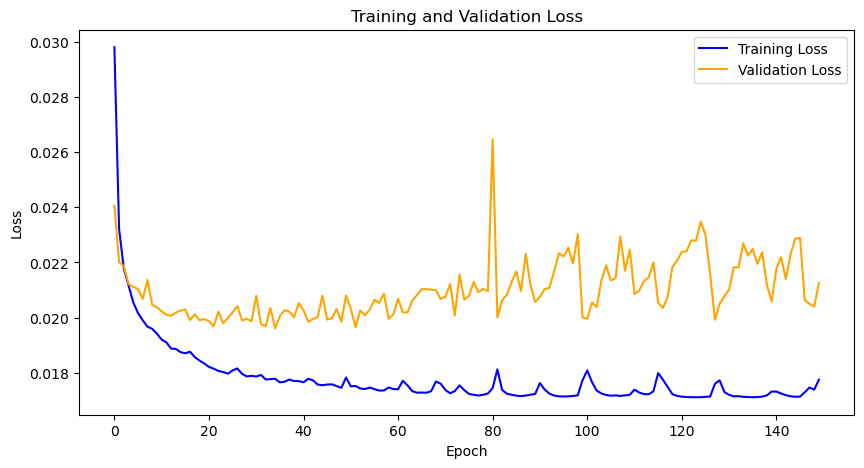

In [37]:
import matplotlib.pyplot as plt

# Get training results
accuracy = results.history['accuracy']
val_accuracy = results.history['val_accuracy']
loss = results.history['loss']
val_loss = results.history['val_loss']

# Plot accuracy
plt.figure(figsize=(10, 5))
plt.plot(accuracy, label='Training Accuracy', color='blue')
plt.plot(val_accuracy, label='Validation Accuracy', color='orange')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.figure(figsize=(10, 5))
plt.plot(loss, label='Training Loss', color='blue')
plt.plot(val_loss, label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [23]:
def plot_accuracy(history):
    # Get training and validation accuracy values
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    # Plot training and validation accuracy
    epochs = range(1, len(train_acc) + 1)
    plt.plot(epochs, train_acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# Example usage:
# Assuming 'history' contains the training history of your model
# You can obtain 'history' by calling model.fit() during training
# model.fit(train_data, train_labels, validation_data=(val_data, val_labels), epochs=10, batch_size=32)
history = vgg19_custom.history
plot_accuracy(history)


KeyError: 'accuracy'

In [35]:
mask_train = vgg19_custom.predict(x_train)

251/251 [==============================] - 361s 1s/step


63/63 [==============================] - 85s 1s/step


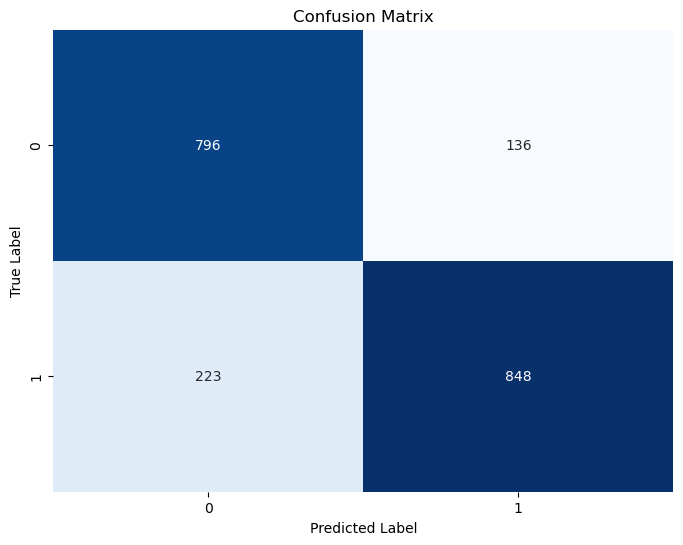

In [36]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Generate predictions for the test set
predictions = vgg19_custom.predict(x_test)

# 2. Convert predictions to binary masks (if needed)
# Example thresholding (adjust threshold value as needed)
threshold = 0.66
predictions_binary = (predictions > threshold).astype(np.uint8)

# Flatten the predictions to match the shape of y_test
# Reshape predictions_binary to match the shape of y_test
y_score = predictions_binary.max(axis=(1, 2, 3))

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_score)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()



In [42]:
import numpy as np

# Calculate misclassification rate
misclassification_rate = (conf_matrix[0, 1] + conf_matrix[1, 0]) / np.sum(conf_matrix)

print("Misclassification rate:", misclassification_rate)


Misclassification rate: 0.17923115327009487


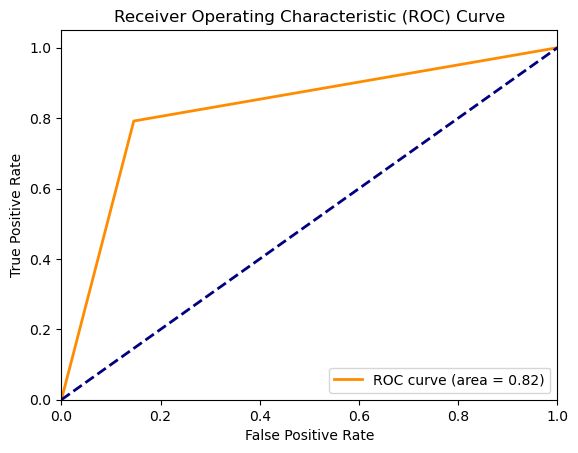

In [38]:
from sklearn.metrics import roc_curve, auc


# Assuming y_test contains the true labels
fpr, tpr, thresholds = roc_curve(y_test, y_score)

# Compute AUC
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


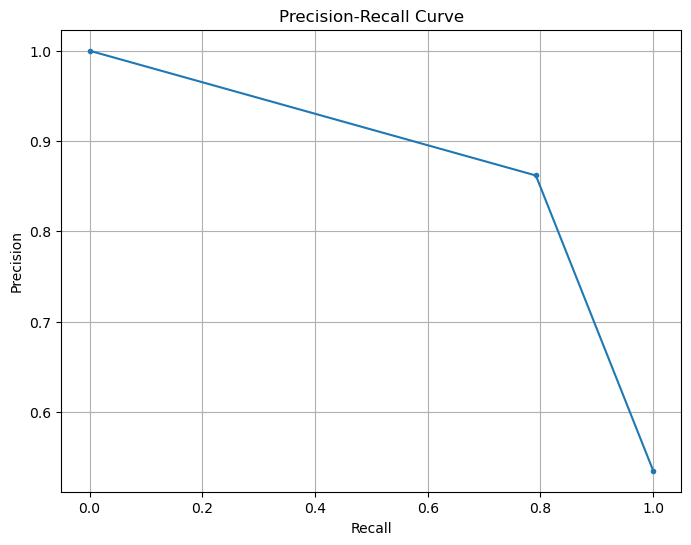

In [39]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Calculate precision and recall
precision, recall, _ = precision_recall_curve(y_test, y_score)

# Plot the Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()


In [40]:
import numpy as np
import tensorflow.keras.backend as K

def mean_iou(y_true, y_pred):
    # Define a function to calculate IoU
    def iou(y_true, y_pred):
        intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
        union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
        iou = K.mean((intersection + K.epsilon()) / (union + K.epsilon()), axis=0)
        return iou
    
    # Compute IoU for each class
    ious = iou(y_true, y_pred)
    # Take the mean over classes (excluding the background)
    return K.mean(ious)

# Compile your model with mIoU as a metric
vgg19_custom.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', mean_iou])


In [41]:
from sklearn.metrics import classification_report

# Assuming y_true and y_pred are your true labels and predicted labels, respectively
# y_true and y_pred should be 1D arrays containing the predicted class labels for each sample

# Classification report
print(classification_report(y_test, y_score))


              precision    recall  f1-score   support

           0       0.78      0.85      0.82       932
           1       0.86      0.79      0.83      1071

    accuracy                           0.82      2003
   macro avg       0.82      0.82      0.82      2003
weighted avg       0.82      0.82      0.82      2003

